## Analysis of CTD data from the Amundson Sea

#### Load packages


In [87]:
import glob, os
import pandas as pd
from pandas.compat import StringIO
import numpy as np
import matplotlib.pyplot as plt
import cmocean 

#### Load data

In [88]:
#load data

path='/home/wizard/Documents/observing_the_ocean/anna_wahlin/exercises/data/Exercise_2/'
import dask.dataframe as dd

df = pd.concat([(pd.read_csv(f,header=None,skiprows=1,nrows=4,sep='\s+=')).transpose().assign(ctd=os.path.basename(f).split('.')[0]) 
               for f in glob.glob(path+'OS*.dat')], ignore_index = True)

df.columns = df.iloc[0]
df=df.reindex(df.index.drop(0))
df=df[df.index % 2 != 0]  
df.rename(columns={'OSO0809_CTD_26058':'ctd'}, inplace=True)

dfHeader=df

df = pd.concat([pd.read_csv(f,sep='\s+',skiprows=7,names=['pres','Temp','S','rho']).assign(ctd=os.path.basename(f).split('.')[0]) 
                for f in glob.glob(path+'OS*.dat')], ignore_index = True)

/home/wizard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


### Plot temperature and salinity as a function of depth

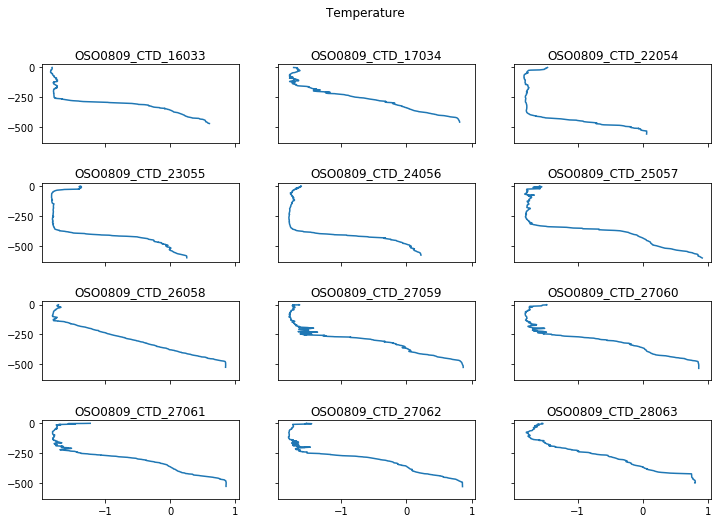

In [89]:
grouped=df.groupby('ctd')
fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharex=True,sharey=True)
fig.suptitle('Temperature') 
targets=zip(ax.flatten(),grouped.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grouped.get_group(key)['Temp'],grouped.get_group(key)['pres']*-1)
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()


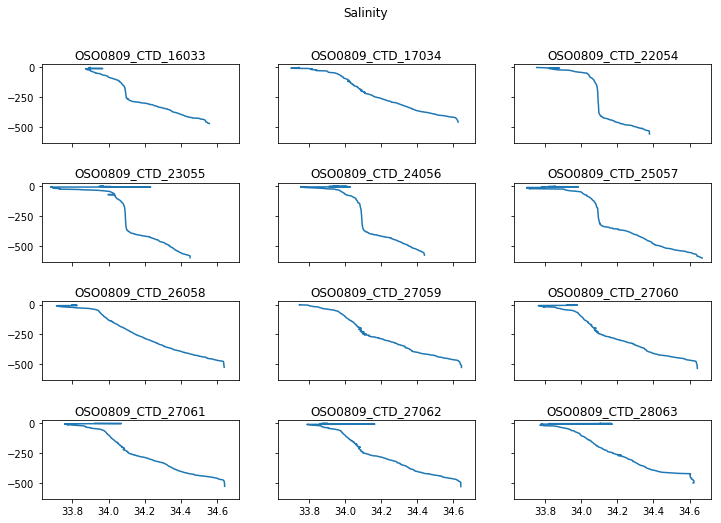

In [90]:
fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharey=True,sharex=True)
fig.suptitle('Salinity')
targets=zip(ax.flatten(),grouped.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grouped.get_group(key)['S'],grouped.get_group(key)['pres']*-1)
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()

### T/S Plot of all stations

Text(0.5,1,'T/S')

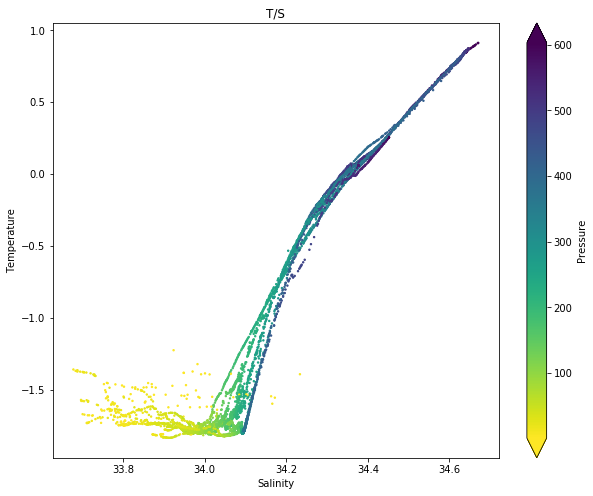

In [91]:
plt.figure(figsize=[10,8])
plt.scatter(df.S,df.Temp,s=2,c=df.pres,cmap='viridis_r')
cbar=plt.colorbar(extend='both')
cbar.set_label('Pressure')
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('T/S')

Water Masses: Winter water, Cicumpolar deep water, MCDW

### Compute and plot density, potential density and neutral density
    

In [92]:
import gsw as gsw
df['pot_dens']=gsw.pot_rho_t_exact(df.S,df.Temp,df.pres,0)-1000

#neutral density

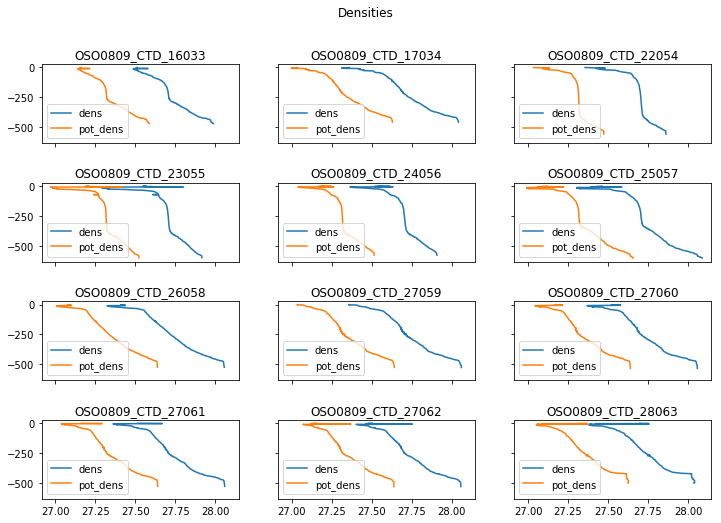

In [93]:
#plot
fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharey=True,sharex=True)
fig.suptitle('Densities')
targets=zip(ax.flatten(),grouped.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grouped.get_group(key)['rho'],grouped.get_group(key)['pres']*-1,label='dens')
    axe.plot(grouped.get_group(key)['pot_dens'],grouped.get_group(key)['pres']*-1,label='pot_dens')
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()
    axe.legend()

### Cross trough transect of temperature, salinity and density

#### Compute distance between stations/


In [94]:
# define distance function
def haversine(lat1, lon1, lat2, lon2):
    import numpy as np
    R=6378.137
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    total_m = (R * c)*1000
    return total_m

#convert lat lon objects to floats
dfHeader['lat']=dfHeader.Start_Lat.astype(float)
dfHeader['lon']=dfHeader.Start_Lon.astype(float)

#compute distance
dfHeader['dist']=np.cumsum(haversine(dfHeader.lat,dfHeader.lon,dfHeader.lat.shift(),dfHeader.lon.shift()))

In [118]:
# function to grid data
def griddata(var,depths,profiles,how='mean',bins=None, interp_lim=4):
    from pandas import cut
    from numpy import arange, array, c_, nanmax

    y = array(var)
    depth = array(depths)
    dives = array(profiles)
    bins = arange(nanmax(depth) + 1)if bins is None else bins
    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(depth, bins, labels=labels)
    grp = pd.Series(y).groupby([dives, bins])
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))
    gridded.index.name = 'depth'
    gridded.columns.name = 'ctd'
    gridded = gridded.reindex(index=labels)
    if interp_lim > 0:
        gridded = gridded.interpolate(limit=interp_lim).bfill(limit=interp_lim)
    return gridded

In [119]:
tg=griddata(df.Temp.T,df.pres,df.ctd).T
sg=griddata(df.S,df.pres,df.ctd).T
dg=griddata(df.pot_dens,df.pres,df.ctd).T
tg.index=(dfHeader.dist)
sg.index=(dfHeader.dist)
dg.index=(dfHeader.dist)

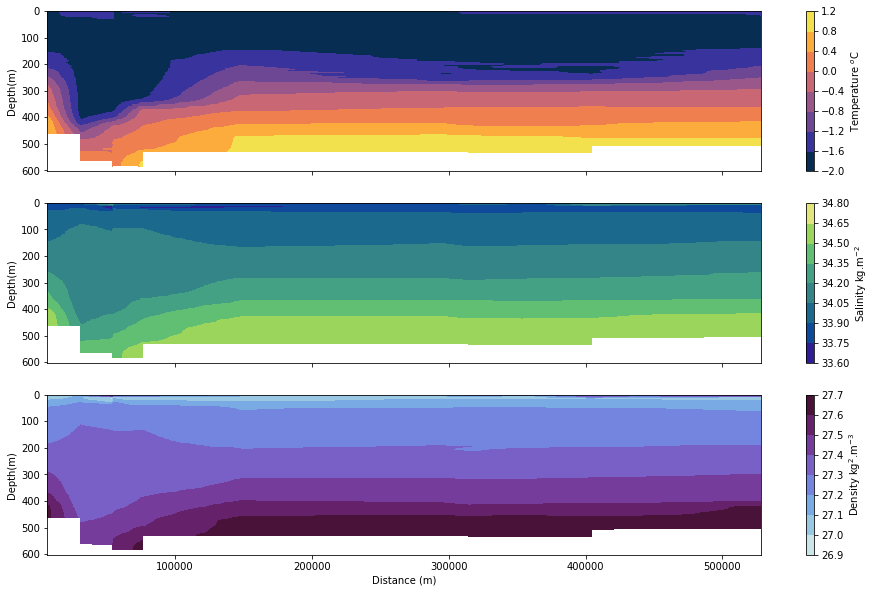

In [115]:
fig,ax=plt.subplots(3,1,figsize=[16,10],sharex=True)
xx,yy=np.meshgrid(tg.index[1:],tg.columns)
tp=ax[0].contourf(xx,yy,tg.iloc[1:,:].T,cmap=cmocean.cm.thermal)
ax[0].invert_yaxis()
ax[0].set_ylabel('Depth(m)')
cbar=plt.colorbar(tp,ax=ax[0])
cbar.set_label('Temperature $^o$C')
sp=ax[1].contourf(xx,yy,sg.iloc[1:,:].T,cmap=cmocean.cm.haline)
ax[1].invert_yaxis()
ax[1].set_ylabel('Depth(m)')
cbar=plt.colorbar(sp,ax=ax[1])
cbar.set_label('Salinity kg.m$^{-2}$')
dp=ax[2].contourf(xx,yy,dg.iloc[1:,:].T,cmap=cmocean.cm.dense)
ax[2].invert_yaxis()
ax[2].set_ylabel('Depth(m)')
ax[2].set_xlabel('Distance (m)')
cbar=plt.colorbar(dp,ax=ax[2])
cbar.set_label('Density kg$^{2}$.m$^{-3}$')


### Compute geostrophic shear


In [229]:
#create distance array
dist_array=dfHeader.dist.repeat(603).values.reshape(12,603)
dens_array=np.asarray(dg)
#compute horizontal density gradient
del_pot_dens0=(dens_array[1:,:]-dens_array[:-1,:])/(dist_array[1:,:]-dist_array[:-1,:])


#### Function to compute coriolis

In [99]:
#compute coriolis acceleration
def coriolis_acc(lat,omega=0.729*10**-4):
    return 2*omega*np.sin(lat/360.*2*np.pi)

f=coriolis_acc(dfHeader.lat)
f_array=f.repeat(603).values.reshape(12,603)

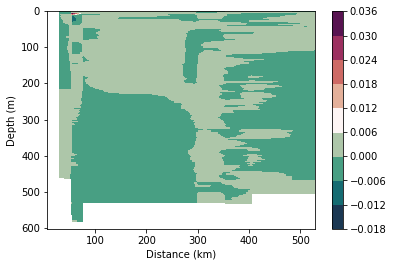

In [100]:
g=9.8 # define gravitaional acceleration
ref_dens=1000.

#compute geostrophic vertical shear using thermal wind equations
geo_vert_shear=-((g/ref_dens)*(del_pot_dens0))/(-f_array[1:,:])
xx,yy=np.meshgrid(tg.index[1:],tg.columns)
plt.contourf(xx/1000,yy,geo_vert_shear.T,cmap=cmocean.cm.curl)
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
plt.colorbar(extend='both')

## Now compare to Lowered ADCP data

#### Load data

In [101]:
df_adcp = pd.concat([pd.read_csv(f,sep='\s+',skiprows=7,names=['z','u','v','ev']).assign(ctd=os.path.basename(f).split('.')[0]) 
                for f in glob.glob(path+'OS*.lad')], ignore_index = True)


### Plot u,v as a function of depth

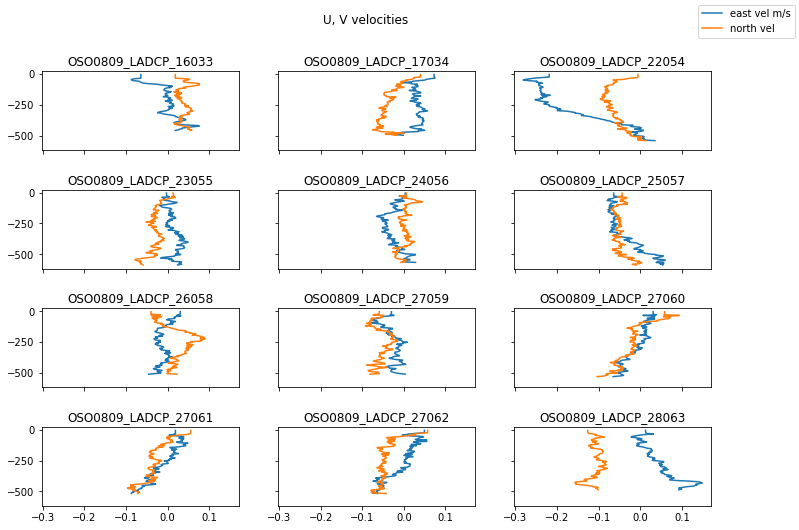

In [102]:
grp_adcp=df_adcp.groupby('ctd')

fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharey=True,sharex=True)
fig.suptitle('U, V velocities')
targets=zip(ax.flatten(),grp_adcp.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grp_adcp.get_group(key)['u'],grp_adcp.get_group(key)['z']*-1,label='east vel m/s')
    axe.plot(grp_adcp.get_group(key)['v'],grp_adcp.get_group(key)['z']*-1,label='north vel')
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()
handles, labels = axe.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

#### Grid the data

In [103]:
ug=griddata(df_adcp.u.T,df_adcp.z,df_adcp.ctd).T
vg=griddata(df_adcp.v.T,df_adcp.z,df_adcp.ctd).T
ug.index=(dfHeader.dist)
vg.index=(dfHeader.dist)

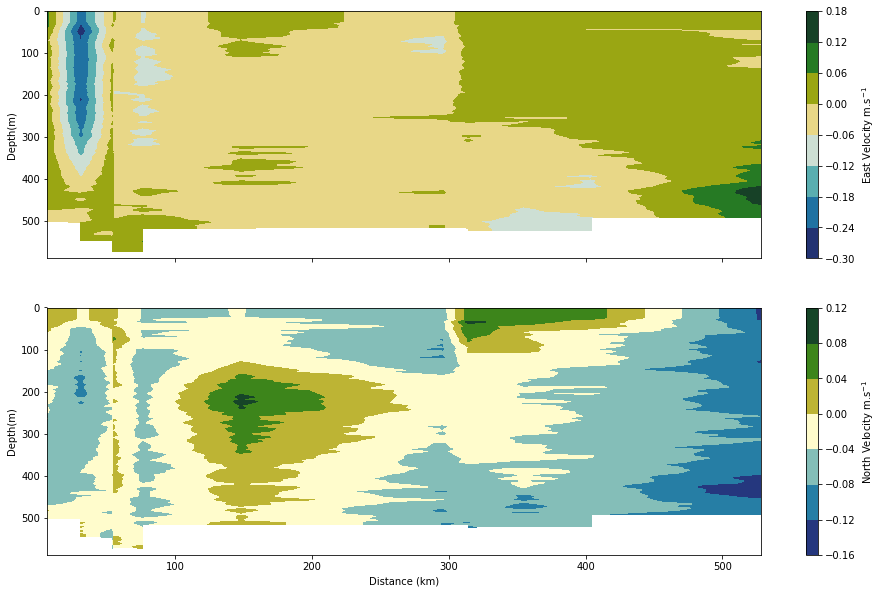

In [104]:
fig,ax=plt.subplots(2,1,figsize=[16,10],sharex=True)
xx,yy=np.meshgrid(ug.index[1:]/1000,ug.columns)

up=ax[0].contourf(xx,yy,ug.iloc[1:,:].T,cmap=cmocean.cm.delta)
ax[0].invert_yaxis()
ax[0].set_ylabel('Depth(m)')
cbar=plt.colorbar(up,ax=ax[0])
cbar.set_label('East Velocity m.s$^{-1}$')
vp=ax[1].contourf(xx,yy,vg.iloc[1:,:].T,cmap=cmocean.cm.delta)
ax[1].invert_yaxis()
ax[1].set_ylabel('Depth(m)')
ax[1].set_xlabel('Distance (km)')

cbar=plt.colorbar(vp,ax=ax[1])
cbar.set_label('North Velocity m.s$^{-1}$')

### Rotate velocty vectors by 37degrees to along and across channel

In [106]:
# per profile
import math as m
df_adcp['along'] = df_adcp.u*np.sin(m.radians(37))+df_adcp.v*np.cos(m.radians(37))
df_adcp['across'] =df_adcp.u*np.cos(m.radians(37))-df_adcp.v*np.sin(m.radians(37))
grp_adcp=df_adcp.groupby('ctd')


In [107]:
#grid transformed data
alongGrd=griddata(df_adcp.along.T,df_adcp.z,df_adcp.ctd).T
acrossGrd=griddata(df_adcp.across.T,df_adcp.z,df_adcp.ctd).T
alongGrd.index=(dfHeader.dist)
acrossGrd.index=(dfHeader.dist)

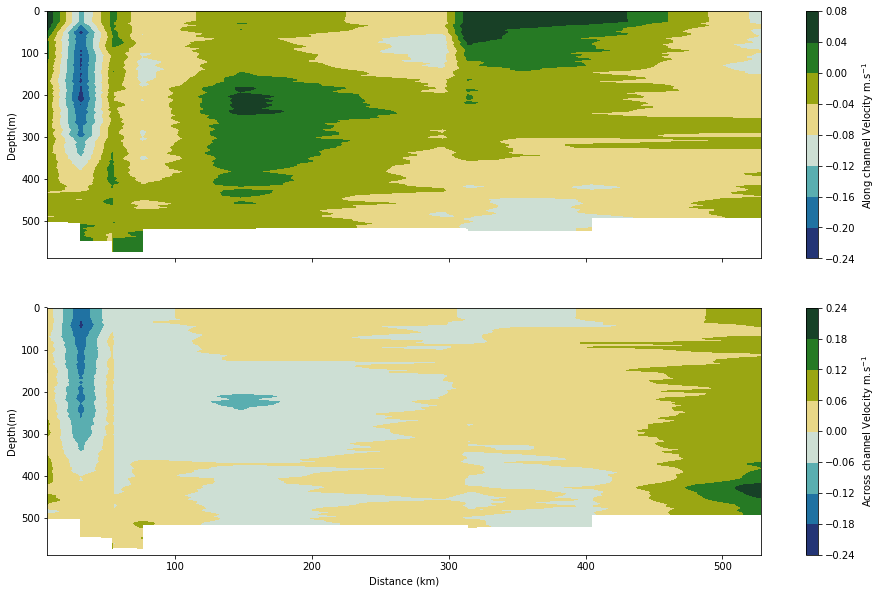

In [108]:
fig,ax=plt.subplots(2,1,figsize=[16,10],sharex=True)
xx,yy=np.meshgrid(ug.index[1:]/1000,ug.columns)

up=ax[0].contourf(xx,yy,alongGrd.iloc[1:,:].T,cmap=cmocean.cm.delta)
ax[0].invert_yaxis()
ax[0].set_ylabel('Depth(m)')
cbar=plt.colorbar(up,ax=ax[0])
cbar.set_label('Along channel Velocity m.s$^{-1}$')
vp=ax[1].contourf(xx,yy,acrossGrd.iloc[1:,:].T,cmap=cmocean.cm.delta)
ax[1].invert_yaxis()
ax[1].set_ylabel('Depth(m)')
ax[1].set_xlabel('Distance (km)')
cbar=plt.colorbar(vp,ax=ax[1])
cbar.set_label('Across channel Velocity m.s$^{-1}$')

In [202]:
### Compute vertical shear of velocities

#unsmoothed data
targets=grp_adcp.groups.keys()
ac_sh=[]
for i, key in enumerate(targets):
    shear_across=grp_adcp.get_group(key)['across'].diff()/grp_adcp.get_group(key)['z'].diff()
    ac_sh.append(shear_across)
ac_sh=np.asarray(ac_sh)
targets

dict_keys(['OSO0809_LADCP_16033', 'OSO0809_LADCP_17034', 'OSO0809_LADCP_22054', 'OSO0809_LADCP_23055', 'OSO0809_LADCP_24056', 'OSO0809_LADCP_25057', 'OSO0809_LADCP_26058', 'OSO0809_LADCP_27059', 'OSO0809_LADCP_27060', 'OSO0809_LADCP_27061', 'OSO0809_LADCP_27062', 'OSO0809_LADCP_28063'])

In [209]:
#grid vertical velocities to 10m bins to smooth the data and reduce noise
bins=np.arange(0,600,10)
alongGrd10=griddata(df_adcp.along.T,df_adcp.z,df_adcp.ctd,bins=bins).T
acrossGrd10=griddata(df_adcp.across.T,df_adcp.z,df_adcp.ctd,bins=bins).T
alongGrd10.index=(dfHeader.dist)
acrossGrd10.index=(dfHeader.dist)

#compute vert shear
vtsh_along10=alongGrd10.diff(axis=1)
vtsh_across10=acrossGrd10.diff(axis=1)


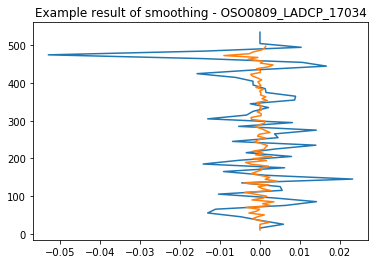

In [230]:
plt.figure()
plt.title('Example result of smoothing - OSO0809_LADCP_17034')
plt.plot(vtsh_across10.iloc[1,:],vtsh_across10.columns,label='smoothed')
plt.plot(ac_sh[1],grp_adcp.get_group('OSO0809_LADCP_17034')['z'],label='raw')



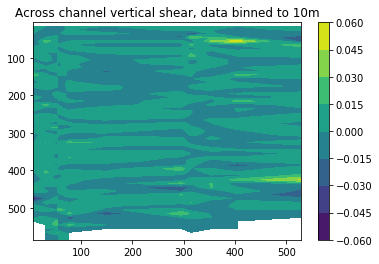

In [214]:
plt.figure()
plt.title('Across channel vertical shear, data binned to 10m')
xx,yy=np.meshgrid(vtsh_across10.index[1:]/1000,vtsh_along10.columns)
plt.contourf(xx,yy,vtsh_across10.iloc[1:,:].T)
plt.gca().invert_yaxis()
plt.colorbar()

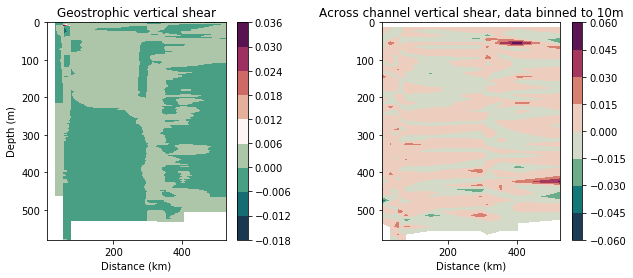

In [224]:
# compare across channel vertical shear to geostrophic vertical shear
fig,ax=plt.subplots(1,2,figsize=[10,4],gridspec_kw=dict(wspace=0.5))

xx,yy=np.meshgrid(tg.index[1:],tg.columns)
geo_shear=ax[0].contourf(xx/1000,yy,geo_vert_shear.T,cmap=cmocean.cm.curl)
ax[0].set_title('Geostrophic vertical shear')
ax[0].invert_yaxis()
ax[0].set_ylim(580,0)
ax[0].set_xlabel('Distance (km)')
ax[0].set_ylabel('Depth (m)')
plt.colorbar(geo_shear,ax=ax[0])

ax[1].set_title('Across channel vertical shear, data binned to 10m')
xx,yy=np.meshgrid(vtsh_across10.index[1:]/1000,vtsh_along10.columns)
adcp_shear=ax[1].contourf(xx,yy,vtsh_across10.iloc[1:,:].T,cmap=cmocean.cm.curl)
ax[1].invert_yaxis()
ax[1].set_ylim(580,0)
ax[1].set_xlabel('Distance (km)')

plt.colorbar(adcp_shear,ax=ax[1])

### Compute baroclinic geostrophic velocity

In [290]:
# geo_vert_shear.shape
bcl_vert_vel=np.cumsum(geo_vert_shear,axis=1)
# # baroclinic_vertical_vel_bot=np.cumsum(geo_vert_shear[:,::-1],axis=1)
nomotion_surf=np.reshape(np.tile(baroclinic_vertical_vel[:,0],603),(11,603))
idx_bot_arr=(~np.isnan(bcl_vert_vel)).cumsum(1).argmax(1)
bcl_vert_vel[8,idx_bot_arr[8]
# nomotion_bot=np.reshape(np.tile(baroclinic_vertical_vel[:,idx_bot_arr],603),(11,603))
idx_200=abs(tg.columns-200.).argmin()
nomotion_200=np.reshape(np.tile(baroclinic_vertical_vel[:,idx_200],603),(11,603))

# nomotion_bot=baroclinic_vertical_vel.isnan[:,-20]
# # idx=abs(dat['pres_en_cours']-1000.).argmin()
# plt.plot(nomotion_surf)
# baroclinic_vertical_vel[2,:]
# bcl_vert_vel= bcl_vert_vel[~np.isnan(bcl_vert_vel)]

bcl_vert_vel_surf=bcl_vert_vel-nomotion_surf
bcl_vert_vel_200=bcl_vert_vel-nomotion_surf


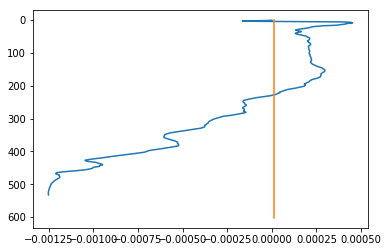

In [297]:
no_motion_surf=bcl_vert_vel[8,0]
plt.plot((bcl_vert_vel[8,:]-no_motion_surf),tg.columns)
plt.plot(np.tile(no_motion_surf,603),tg.columns)
plt.gca().invert_yaxis()

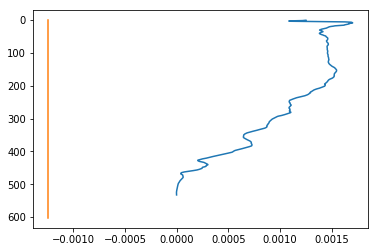

In [296]:
no_motion_bot=bcl_vert_vel[8,idx_bot_arr[8]]
plt.plot((bcl_vert_vel[8,:]-no_motion_bot),tg.columns)
plt.plot(np.tile(no_motion_bot,603),tg.columns)
plt.gca().invert_yaxis()

In [299]:
bcl_vert_vel[8,idx_bot_arr[8]]


-0.0012416929769405829

In [301]:
idx_200=abs(tg.columns-200.).argmin()
nomotion200=bcl_vert_vel[8,idx_200]

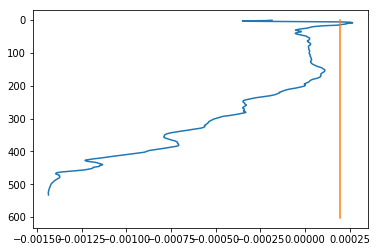

In [303]:
plt.plot((bcl_vert_vel[8,:]-nomotion200),tg.columns)
plt.plot(np.tile(nomotion200,603),tg.columns)
plt.gca().invert_yaxis()